# Project: Wrangling and Analyze Data


## Introduction

1. In this notebook I will be wrangling(and analyzing and visualizing) the tweet archive of <a href='https://twitter.com/dog_rates'>@dog_rates</a> also known as <a href='https://en.wikipedia.org/wiki/WeRateDogs'>WeRateDogs</a>. 

2. I will be following the following workflow:

    Step 1: Gathering data - Using the python <a href='https://requests.readthedocs.io/en/latest/'>requests</a> library and the <a href='https://developer.twitter.com/en/docs/twitter-api'>Twitter API</a> and downloading a csv file from this <a href='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'>link</a>

    Step 2: Assessing data - Using both visual and programmatic methods.

    Step 3: Cleaning data - Programmatically using the <a href='https://pandas.pydata.org/'>Pandas</a> Library.

    Step 4: Storing data - In a csv file.

    Step 5: Analyzing, and visualizing data - Programmatically using <a href='https://matplotlib.org./'>Matplotlib</a>.

    Step 6: Reporting: data wrangling efforts - <a href='wrangle_report.html'>wrangle_act</a>,
      data analyses and visualizations - <a href='act_report.html'>act_report</a>.


In [4]:
# Import libraries
import os
import re
import json
import time
import tweepy
import config
import requests
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import Image, Video
%matplotlib inline

sn.set()

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [5]:
# Load twitter-archive-enhaced.csv into a pandas dataframe
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [6]:
# Get image-predictions.tsv and write to file image_predictions.csv to local folder
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file = 'image_predictions.csv'
try:
    if file not in os.listdir():
        with open('image_predictions.tsv', mode='wb') as f:
            response = requests.get(url)
            f.write(response.content)
except Exception as e:
    print(e)
predictions = pd.read_csv('image_predictions.tsv', delimiter='\t')
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
# Authorizing and instatiating a Auth user handler object
auth = tweepy.OAuth1UserHandler(
   config.api_key, config.api_secret, config.access_token, config.access_secret
)

# Instantiating and Accessing the API object for queries
api = tweepy.API(auth)

In [8]:
# Get tweets
length = len(archive) # number of tweets to get
error = {} # Empty dictionary to catch errors and the tweet_ids
file = 'tweet_json.txt' # file to write json data

# Get the start time
start = time.time()

# Check if tweet_json.txt exist in folder 
if file not in os.listdir():
    # Open file in write mode    
    with open(file, 'w') as f:
        # Loop through each tweet_id in archive dataframe    
        for i in range(0, length, 100):
            # Try connect and get tweet metadata
            try:
                # Query API and get a list of tweets in chunks of 100
                tweets = api.lookup_statuses([i for i in archive.tweet_id[i:i+100]],
                                                 tweet_mode='extended')
                # Loop through the list of tweets and extracts the json 
                for tweet in tweets:
                    # Write the json data to the file
                    json.dump(tweet._json, f)
                    # Create a new line after every json dump
                    f.write('\n')
            # Catch errors and append them to the error dictionary
            except tweepy.TweepyException as e:
                error[f'{tweet_id}'] = e
# Get end time and print the time it took to run the code block
end = time.time()
time_elapsed = end - start
print(time_elapsed)

0.000484466552734375


In [9]:
# See Errors
error

{}

In [10]:
# Create empty list
dict_list = []

# Open tweet_json.txt in read mode
with open('tweet_json.txt', 'r') as j_file:
    
    # Read each line in the document
    for line in j_file.readlines():
        
        # Load each line as a json object
        line = json.loads(line)
        
        # Create dictionary and extract all needed from the json objects
        j_dict = {
            'tweet_id': line['id'],
            'timestamp': line['created_at'],
            'retweet_count': line['retweet_count'],
            'like_count': line['favorite_count']
        }
        # Append each dictionary to the tweet_json list
        dict_list.append(j_dict)

# Tranform list into a dataframe
tweet_json = pd.DataFrame(dict_list)
tweet_json.head()

,tweet_id,timestamp,retweet_count,like_count
0,876484053909872640,Sun Jun 18 16:57:37 +0000 2017,1989,16509
1,886366144734445568,Sat Jul 15 23:25:31 +0000 2017,2613,18484
2,877611172832227328,Wed Jun 21 19:36:23 +0000 2017,70,0
3,888078434458587136,Thu Jul 20 16:49:33 +0000 2017,2885,19095
4,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,7191,36781


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [11]:
# See archive observations
archive.shape

(2356, 17)

In [12]:
# See archive summary info
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
# See predictions summary info
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
# See tweet_json summary info
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       2327 non-null   int64 
 1   timestamp      2327 non-null   object
 2   retweet_count  2327 non-null   int64 
 3   like_count     2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


In [15]:
# Check archive random sample
archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
820,770414278348247044,NaN,NaN,2016-08-30 00:14:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Al Cabone. He's a gangsta puppa. Rather h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770414278...,11,10,Al,None,None,None,None
1583,687102708889812993,NaN,NaN,2016-01-13 02:43:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Army of water dogs here. None of them know whe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687102708...,5,10,None,None,None,None,None
1679,682032003584274432,NaN,NaN,2015-12-30 02:54:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ulysses. He likes holding hands and hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682032003...,11,10,Ulysses,None,None,None,None
51,882268110199369728,NaN,NaN,2017-07-04 16:01:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Alfy. You're witnessing his first wate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882268110...,13,10,Alfy,None,None,None,None
1471,693993230313091072,NaN,NaN,2016-02-01 03:04:14 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",These lil fellas are the best of friends. 12/1...,NaN,NaN,NaN,https://vine.co/v/i5ETazP5hrm,12,10,None,None,None,None,None
2080,670823764196741120,NaN,NaN,2015-11-29 04:37:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Remington. He's a man dime. 12/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670823764...,12,10,Remington,None,None,None,None
1907,674447403907457024,NaN,NaN,2015-12-09 04:36:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper just wants a belly rub. This puppe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674447403...,10,10,None,None,None,pupper,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
882,760290219849637889,NaN,NaN,2016-08-02 01:44:48 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Rocco. He's doing his best. 13/10 some...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760290219...,13,10,Rocco,None,None,None,None
1657,683142553609318400,NaN,NaN,2016-01-02 04:27:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Brandy. She's a member of the Bloods. Men...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683142553...,9,10,Brandy,None,None,pupper,None


In [16]:
# Check predictions random sample
predictions.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
77,667437278097252352,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1,porcupine,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False
311,671544874165002241,https://pbs.twimg.com/media/CVHOgDvU4AAfrXD.jpg,1,feather_boa,0.240858,False,wig,0.085946,False,wool,0.040674,False
809,692158366030913536,https://pbs.twimg.com/media/CZsKVxfWQAAXy2u.jpg,1,pug,0.956565,True,swing,0.018907,False,toy_poodle,0.013544,True
1014,709566166965075968,https://pbs.twimg.com/media/Cdjiqi6XIAIUOg-.jpg,1,chow,0.999837,True,Tibetan_mastiff,0.000117,True,Australian_terrier,0.000011,True
414,674008982932058114,https://pbs.twimg.com/media/CVqPkVoU4AAkXA7.jpg,1,jigsaw_puzzle,0.970810,False,prayer_rug,0.011048,False,quill,0.008432,False
1555,793195938047070209,https://pbs.twimg.com/media/CwH_foYWgAEvTyI.jpg,2,Labrador_retriever,0.654762,True,golden_retriever,0.074100,True,Chihuahua,0.042339,True
473,675146535592706048,https://pbs.twimg.com/media/CV6aMToXIAA7kH4.jpg,1,dingo,0.288447,False,Cardigan,0.229944,True,Pembroke,0.190407,True
320,671789708968640512,https://pbs.twimg.com/tweet_video_thumb/CVKtH-...,1,dalmatian,0.114259,True,teddy,0.062275,False,steam_locomotive,0.049700,False
1335,758041019896193024,https://pbs.twimg.com/media/CoUaSKEXYAAYsAl.jpg,1,bookshop,0.794272,False,Cardigan,0.051265,True,Bernese_mountain_dog,0.026596,True
872,697990423684476929,https://pbs.twimg.com/media/Ca_ClYOW0AAsvpE.jpg,2,Pembroke,0.984783,True,Cardigan,0.015018,True,Shetland_sheepdog,0.000074,True


In [17]:
# Check for duplicates in archive
archive.duplicated().sum()

0

In [18]:
# Check for duplicates in predictions
predictions.duplicated().sum()

0

In [19]:
# Check for duplicates in tweet_json
tweet_json.duplicated().sum()

0

In [20]:
# See Summary stats for meaningful numeric columns
archive.drop(columns=[i for i in list(archive) if '_id' in i]).describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [21]:
# See summary stats for tweet_json
tweet_json.drop('tweet_id', axis=1).describe()

,retweet_count,like_count
count,2327.000000,2327.000000
mean,2458.658788,7025.916201
std,4163.665720,10918.668689
min,1.000000,0.000000
25%,492.500000,1220.500000
50%,1144.000000,3037.000000
75%,2844.500000,8564.000000
max,70330.000000,144245.000000


### Quality issues

1. `timestamp` column datatype is `object` in `archive`.

2. Both `in_reply` columns have only 78 non-null values in `archive`.

3. All `retweeted` colums have only 181 non-null values in `archive`.

4. Dog name of row `275` is  `10` in `archive` and others are random letters or words(Visual asessment).

5. Some dog types are missing even though are contained in the `text` and others are wrong.

6. The source column values contain `HTML` tags and other irrelevant information.

7. `expanded_urls` is not human friendly.

8. `tweet id` column values are of type `int` in all dataframes.

9. `image_predictions` dataframe has 2075 observations.

10. `tweet_json` dataframe has 2327 observations. 

11. `rating_numerator` has a maximum value of 1776.

### Tidiness issues
1. `doggo`, `floofer`, `pupper`, `puppo` should be observations and not columns(Visual Assesment).

2. `tweet_json` should be part of `archive`(Visual Assesment).

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [22]:
# Make copies of original dataframes
archive_clean = archive.copy()
predictions_clean = predictions.copy()
tweet_json_clean = tweet_json.copy()

### Issue #1:

#### Define:

- Change the `timestamp` column datatype in `archive` to `datetime`.

#### Code

In [23]:
# Changing timestamp col datatype
archive_clean['timestamp'] = pd.to_datetime(archive_clean.timestamp)

#### Test

In [24]:
# See changes 
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #2:

#### Define

- Drop columns with a lot of missing values.

#### Code

In [25]:
# Drop cols with over 90% null values
archive_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id',\
                            'retweeted_status_id','retweeted_status_user_id',\
                            'retweeted_status_timestamp' ], inplace=True)

#### Test

In [26]:
# See changes
archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### Issue #3:

#### Define
- Change invalid dog names in the `archive` `name` column to None.



#### Code

In [27]:
# Replace invalid dog names with None
archive_clean['name'] = archive_clean.name.str.replace('\d+|^[a-z]', 'None', regex=True)

### Test

In [28]:
# See Changes
archive_clean.name.value_counts()

None          800
Charlie        12
Oliver         11
Lucy           11
Cooper         11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 955, dtype: int64

In [29]:
archive_clean.name[275]

'None'

### Issue#4:



#### Define

- Extract `doggo`,`floofer`,`pupper`,`puppo` from `text` col and replace `None` with `NaN`.


#### Code

In [30]:
# Extract dog types from text col and drop type cols
archive_clean['dog_stage'] = archive_clean.text.str.extract('(floofer|doggo|pupper|puppo)', expand=True)
archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

# Replace None in dog_stage with NaNs
archive_clean['dog_stage'] = archive_clean.dog_stage.str.replace('None', '')
archive_clean.loc[archive_clean.dog_stage == '', 'dog_stage'] = np.nan

#### Test

In [31]:
# See Changes
archive_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN


In [32]:
# See Extraction
archive_clean.dog_stage.value_counts()

pupper     265
doggo       93
puppo       37
floofer      4
Name: dog_stage, dtype: int64

In [33]:
# See Changes
archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN


### Issue#5:


#### Define

- Extract only the text containing the source of the tweet and the source url.


#### Code

In [34]:
# Create source_text and source_urls from source col
archive_clean['source_text'] = archive_clean.source.str.extract('>([A-Za-z].+)<')[0]
archive_clean['source_url'] = archive_clean.source.str.extract('([a-z]+://.+)("\s)')[0]
# Drop source col
archive_clean.drop('source', axis=1,inplace=True)

#### Test

In [35]:
# See Changes
archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,source_text,source_url
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,Twitter for iPhone,http://twitter.com/download/iphone
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,Twitter for iPhone,http://twitter.com/download/iphone
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,Twitter for iPhone,http://twitter.com/download/iphone
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,Twitter for iPhone,http://twitter.com/download/iphone
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,Twitter for iPhone,http://twitter.com/download/iphone


### Issue#6:


#### Define

- Rename the expanded_urls column to tweet_url since it points to the specific tweet.


#### Code

In [36]:
# Rename expanded_urls col
archive_clean.rename(columns={'expanded_urls': 'tweet_url'}, inplace=True)

#### Test

In [37]:
# See Changes
archive_clean.head(1)

,tweet_id,timestamp,text,tweet_url,rating_numerator,rating_denominator,name,dog_stage,source_text,source_url
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,Twitter for iPhone,http://twitter.com/download/iphone


### Issue#7:

#### Define

- Change all `tweet_id` column datatypes from `int` type to `str` type.



#### Code

In [38]:
# Change all tweet_id datatypes to str type
archive_clean['tweet_id'] = archive_clean.tweet_id.astype(str)
predictions_clean['tweet_id'] = predictions_clean.tweet_id.astype(str)
tweet_json_clean['tweet_id'] = tweet_json_clean.tweet_id.astype(str)

#### Test

In [39]:
# See Changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   object             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   text                2356 non-null   object             
 3   tweet_url           2297 non-null   object             
 4   rating_numerator    2356 non-null   int64              
 5   rating_denominator  2356 non-null   int64              
 6   name                2356 non-null   object             
 7   dog_stage           399 non-null    object             
 8   source_text         2356 non-null   object             
 9   source_url          2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(7)
memory usage: 184.2+ KB


In [40]:
# See Changes
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [41]:
# See Changes
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       2327 non-null   object
 1   timestamp      2327 non-null   object
 2   retweet_count  2327 non-null   int64 
 3   like_count     2327 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 72.8+ KB


### Issue#8:

#### Define

- Merge archive and tweet_json dataframes.



#### Code

In [42]:
# Merge archive and tweet_json dataframes
df_merge = pd.merge(archive_clean,
                    tweet_json_clean.drop('timestamp',axis=1), on='tweet_id')

#### Test

In [43]:
# See Changes
df_merge.head(2)

,tweet_id,timestamp,text,tweet_url,rating_numerator,rating_denominator,name,dog_stage,source_text,source_url,retweet_count,like_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,Twitter for iPhone,http://twitter.com/download/iphone,6969,33692
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,Twitter for iPhone,http://twitter.com/download/iphone,5272,29218


### Issue#9:


#### Define

- Ensure decimal numerator ratings match the actual rating

#### Code

In [44]:
# Extract ratings from the text col, both whole and decimal
archive_clean['rating_numerator'] = archive_clean.text.str.extract(r'(\d+\.\d*|\d+\/\d+)')

#### Test

In [45]:
# See Changes
archive_clean[archive_clean.rating_numerator == '13.5']

,tweet_id,timestamp,text,tweet_url,rating_numerator,rating_denominator,name,dog_stage,source_text,source_url
45,883482846933004288,2017-07-08 00:28:19+00:00,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10,Bella,NaN,Twitter for iPhone,http://twitter.com/download/iphone


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [46]:
# Merge all dataframes and save to csv
master_df = pd.merge(df_merge, predictions_clean, on='tweet_id')

In [47]:
# See number of observations
master_df.shape

(2057, 23)

In [48]:
# Save master dataframe to a csv file.
master_df.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [49]:
# Read the master csv file into a pandas dataframe
df = pd.read_csv('twitter_archive_master.csv')
df.head(2)

,tweet_id,timestamp,text,tweet_url,rating_numerator,rating_denominator,name,dog_stage,source_text,source_url,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,Twitter for iPhone,http://twitter.com/download/iphone,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,Twitter for iPhone,http://twitter.com/download/iphone,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [50]:
# See df summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2057 non-null   int64  
 1   timestamp           2057 non-null   object 
 2   text                2057 non-null   object 
 3   tweet_url           2057 non-null   object 
 4   rating_numerator    2057 non-null   int64  
 5   rating_denominator  2057 non-null   int64  
 6   name                2057 non-null   object 
 7   dog_stage           334 non-null    object 
 8   source_text         2057 non-null   object 
 9   source_url          2057 non-null   object 
 10  retweet_count       2057 non-null   int64  
 11  like_count          2057 non-null   int64  
 12  jpg_url             2057 non-null   object 
 13  img_num             2057 non-null   int64  
 14  p1                  2057 non-null   object 
 15  p1_conf             2057 non-null   float64
 16  p1_dog

In [51]:
# Get dogs classified as dogs in all probability levels
dog_class = df.query('p1_dog == True & p2_dog == True & p3_dog == True')

In [52]:
# See dog_class sample size
dog_class.shape

(1232, 23)

In [53]:
# Get top 5 dogs with a high probability 1 
top_5 = dog_class.groupby(['tweet_id', 'p1']).p1_conf.nlargest(1).sort_values(ascending=False)[:5]
top_5

tweet_id            p1                      
697463031882764288  Labrador_retriever  1192    0.999885
675149409102012420  chow                1581    0.999876
709566166965075968  chow                1043    0.999837
814986499976527872  dalmatian           376     0.999828
777621514455814149  chow                606     0.999823
Name: p1_conf, dtype: float64

In [54]:
# Get bottom 5 dogs with a low probability 1
bottom_5 = dog_class.groupby(['tweet_id', 'p1']).p1_conf.nlargest(1).sort_values(ascending=False)[-5:]
bottom_5

tweet_id            p1                      
698262614669991936  Italian_greyhound   1181    0.107948
686683045143953408  Norwich_terrier     1326    0.100499
683773439333797890  miniature_pinscher  1377    0.072885
668507509523615744  basenji             1920    0.055379
666644823164719104  Ibizan_hound        2018    0.044333
Name: p1_conf, dtype: float64

In [55]:
# Get top 5 highly rated dogs
top_rated = df.groupby(['tweet_id','p1']).rating_numerator.nlargest(1).sort_values(ascending=False)[:1]
top_rated

tweet_id            p1          
749981277374128128  bow_tie  787    1776
Name: rating_numerator, dtype: int64

In [56]:
# Get top 5 most retweeted dog types
retweet = df.groupby(['tweet_id']).retweet_count.nlargest(1).sort_values(ascending=False)[:1]
retweet

tweet_id               
744234799360020481  836    70330
Name: retweet_count, dtype: int64

In [57]:
# Get top 5 most liked dog type tweets
favourite = df.groupby(['tweet_id']).like_count.nlargest(1).sort_values(ascending=False)[:1]
favourite

tweet_id               
744234799360020481  836    144245
Name: like_count, dtype: int64

In [58]:
# Url picture for the top classified dog
url_top = df.query('tweet_id == 697463031882764288').jpg_url
url_top

1192    https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg
Name: jpg_url, dtype: object

In [59]:
# Url picture for the bottom poorly classified dog
url_bottom = df.query('tweet_id == 666644823164719104').jpg_url
url_bottom

2018    https://pbs.twimg.com/media/CUBl6IwVAAA9_zT.jpg
Name: jpg_url, dtype: object

In [60]:
# Url for the dog with the highest dog rating
url_rated = df.query('tweet_id == 749981277374128128').jpg_url
url_rated

787    https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg
Name: jpg_url, dtype: object

In [61]:
# Get all dogs not classified as dogs in all probability levels
not_dogs = df.query('p1_dog == False & p2_dog == False & p3_dog == False')

In [63]:
# Get the dog type most wrongly classified and what it was classified as
not_dogs.groupby(['p1', 'p2', 'p3']).dog_stage.value_counts().nlargest(1)

p1         p2           p3           dog_stage
mousetrap  black_widow  paddlewheel  pupper       2
Name: dog_stage, dtype: int64

In [64]:
wrong = not_dogs.dog_stage.value_counts()
wrong

pupper    42
doggo     11
puppo      1
Name: dog_stage, dtype: int64

In [65]:
# Get picture url for the poorly classified dog
df.query('p1=="mousetrap" & p2=="black_widow" & p3=="paddlewheel"').jpg_url

457    https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg
613    https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg
Name: jpg_url, dtype: object

### Insights:

1. The dog breed classified with the highest probability was the `Labrador_retriever`, which from my judgement was spot on, see the picture in `Visualization` section. You can read more about the dog breed <a href='https://en.wikipedia.org/wiki/Labrador_Retriever'>here.</a>

2. The algorithm works better on pictures that are clear and with better focus, the poorest classified dog breed's picture was a bit blurry and the dog was not clearly visible. which might be the reason for the poor classification and once more to make the statement even more concrete the dog that was classified as objets had a not so great picture. But that does not take away the fact that the picture was adorable, see it below in the `Visualization` section.
 
3. The top rated dog really deserved the rating as him/her and his/her owner really went out of their way to put on a presentation and for him/her to sit through the time to get the costume on really proves he/she lived up to the group he/she belongs. He/she is a REALLY GOOD DOG, BRENT!!

4. There is one dog in particular associated with the highest retweets, reply count, and like count. It is highly likely that there more retweets a tweet gets, the more people engage and the more people are likely interested in the tweet.

5. When the classification algorithm classifies wrong, It really CLASSIFIES WRONG! proof being the dog classified as a mousetrap, paddle wheel and a black widow.

### Visualization

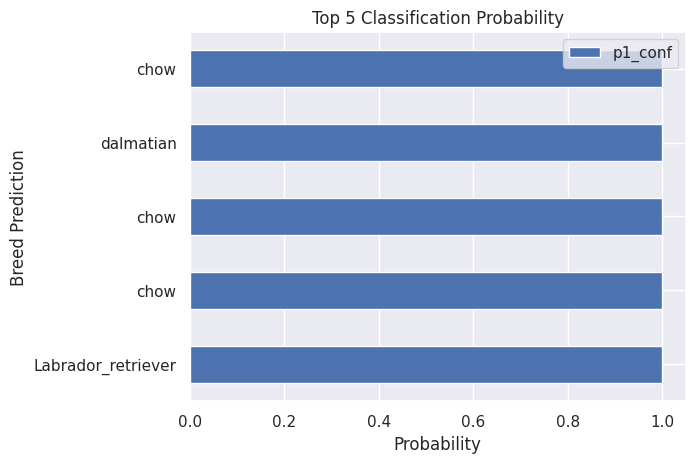

In [66]:
# Creating the data and plotting
data_top = top_5.reset_index().drop(columns=['tweet_id', 'level_2']).set_index('p1')
data_top.plot(kind='barh')
plt.title('Top 5 Classification Probability')
plt.xlabel('Probability')
plt.ylabel('Breed Prediction')
plt.savefig('top.png', bbox_inches='tight');

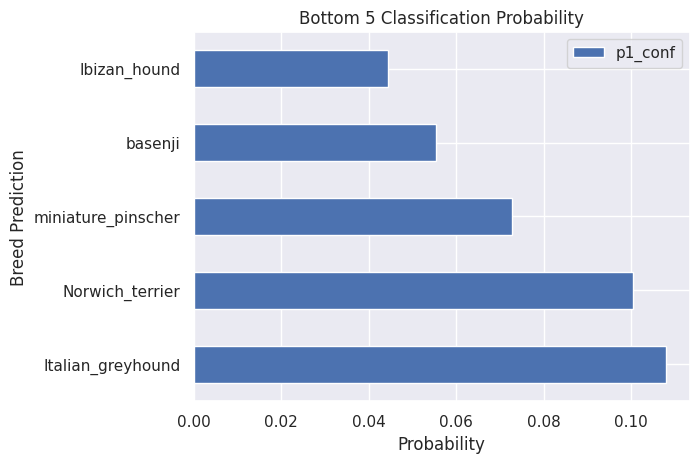

In [67]:
# Creating the data and plotting
data_bottom = bottom_5.reset_index().drop(columns=['tweet_id', 'level_2']).set_index('p1')
data_bottom.plot(kind='barh')
plt.title('Bottom 5 Classification Probability')
plt.xlabel('Probability')
plt.ylabel('Breed Prediction')
plt.savefig('bottom.png', bbox_inches='tight');

#### Correctly classified dog breed

In [68]:
# Picture of the top classed with high probability dog
Image(url='https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg')

In [69]:
# Picture of the dog classed with the lowest probability level 1
Image(url='https://pbs.twimg.com/media/CUBl6IwVAAA9_zT.jpg')

In [70]:
# Picture of the dog associated with the highest rating
Image(url='https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg')

In [71]:
# Picture of the dog classified as object in all levels of probability
Image(url='https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg')